Mean Abs Tracking Error (power-domain): 1,467 kW
Saved results to: logs\mpc_block_energy_results.csv
Saved block energy diagnostic: logs\block_060000_energy.png
Saved block energy diagnostic: logs\block_090000_energy.png


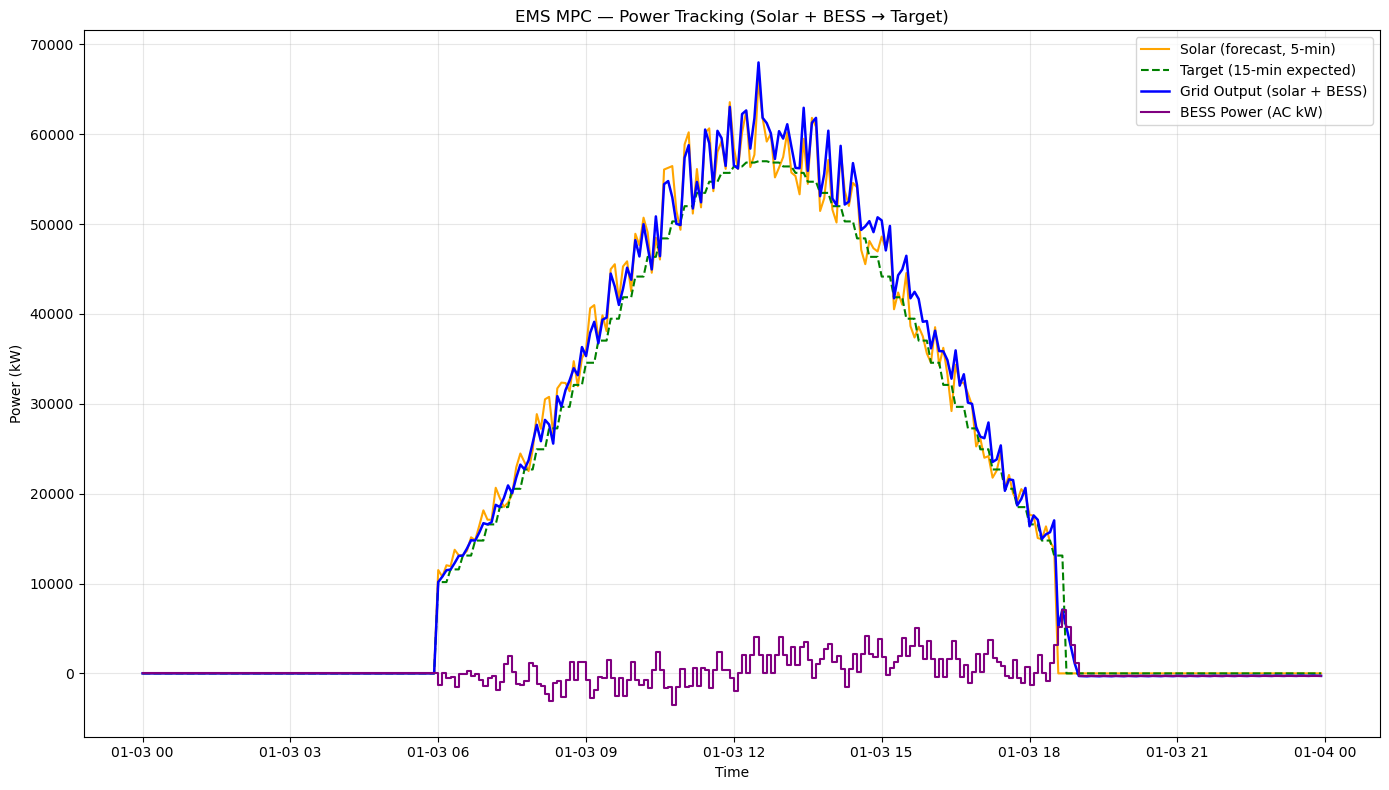

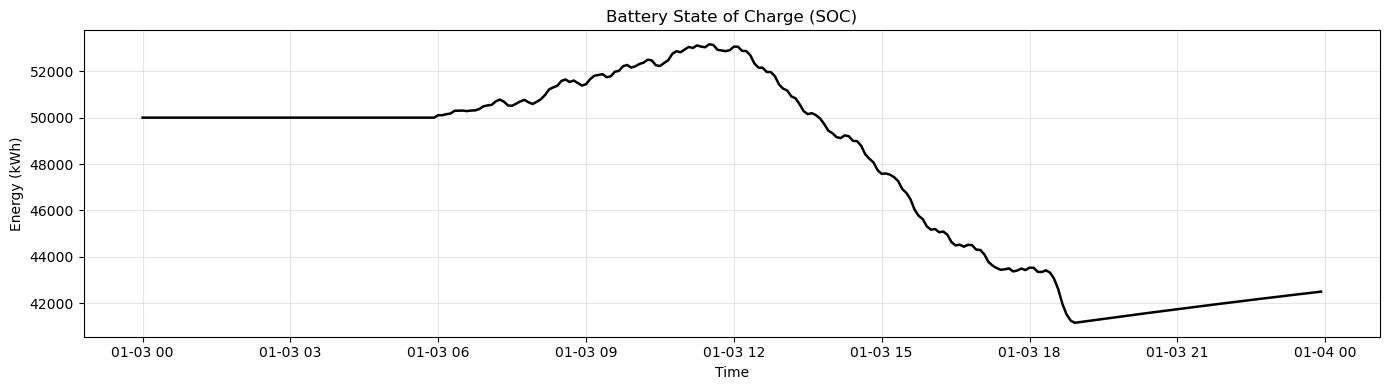

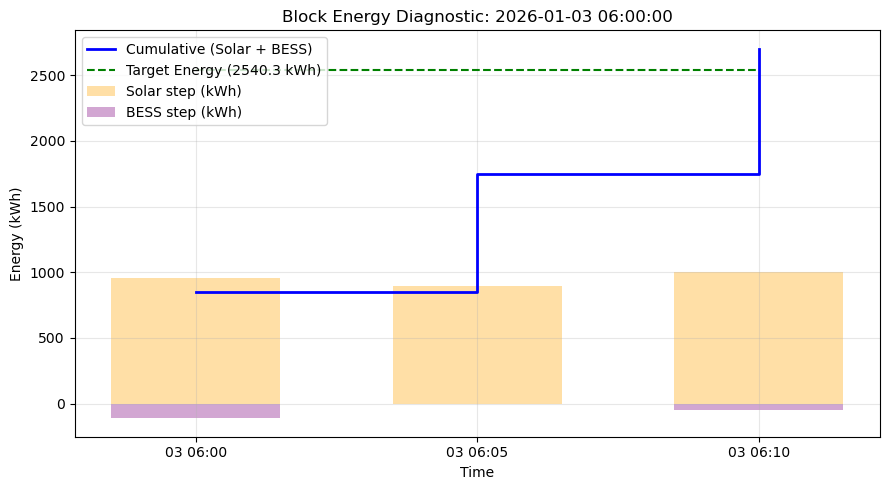

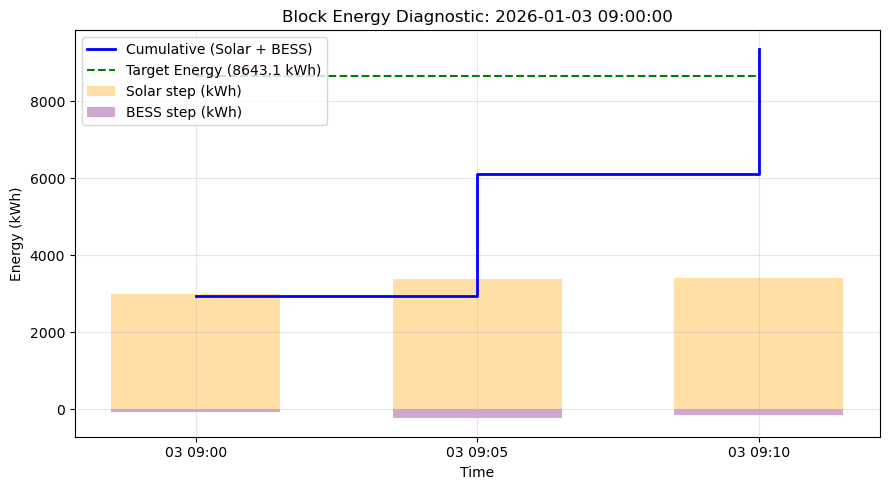

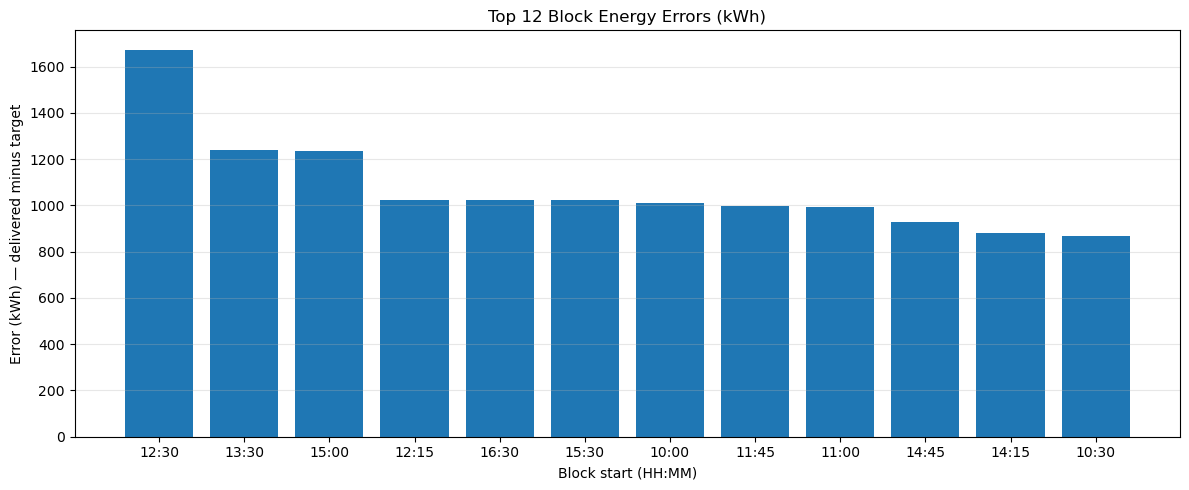

In [1]:

# main.py
# Run the EMS MPC (block energy) for a full day

import os
from importlib import import_module
import pandas as pd

from src.io.data_loader import (
    read_day_ahead_power_15min, read_forecast_5min, read_actual_5min, build_tracking_frame
)
from src.simulation.simulator import run_day_with_block_energy_mpc
from src.plotting.plots import plot_day, plot_soc, plot_block_energy, plot_block_energy_errors_summary

def main():
    # Load config
    CONFIG = import_module("config").CONFIG

    # Ensure folders
    os.makedirs(CONFIG["tracking"]["log_dir"], exist_ok=True)

    # Data paths
    da_path  = "data/day_ahead_15min.csv"
    fc5_path = "data/rt_5min.csv"
    act5_path = "data/solar_actual_5min.csv"  # optional

    # Read inputs
    df15 = read_day_ahead_power_15min(da_path)
    df5f = read_forecast_5min(fc5_path)
    try:
        df5a = read_actual_5min(act5_path)
    except FileNotFoundError:
        df5a = None

    # Build tracking frame (maps 5-min rows to 15-min blocks with E_target_kwh)
    tracking = build_tracking_frame(df15, df5f, df5a, dt5_min=CONFIG["time"]["dt_minutes_rtu"])

    # Run MPC simulation
    df = run_day_with_block_energy_mpc(CONFIG, tracking)

    # Save CSV results
    out_csv = os.path.join(CONFIG["tracking"]["log_dir"], "mpc_block_energy_results.csv")
    df.to_csv(out_csv, index=False)

    # Plots
    if CONFIG["tracking"]["save_plots"]:
        plot_day(df, os.path.join(CONFIG["tracking"]["log_dir"], "power_tracking.png"))
        plot_soc(df, os.path.join(CONFIG["tracking"]["log_dir"], "soc.png"))

    # Summary: tracking error (power-domain; quick view)
    mae_kw = (df["grid_output_kw"] - df["target_power_kw"]).abs().mean()
    print(f"Mean Abs Tracking Error (power-domain): {mae_kw:,.0f} kW")
    print(f"Saved results to: {out_csv}")


    # main.py (after plotting day/SOC)
    # Block energy diagnostics (e.g., 06:00 and 09:00 blocks)
    for hh in ["06:00:00", "09:00:00"]:
        ts_block = pd.Timestamp(f"{df['timestamp'].dt.date.iloc[0]} {hh}")
        out_png = os.path.join(CONFIG["tracking"]["log_dir"], f"block_{hh.replace(':','')}_energy.png")
        try:
            plot_block_energy(df, ts_block, out_png)
            print(f"Saved block energy diagnostic: {out_png}")
        except Exception as e:
            print(f"Block {hh} diagnostic skipped: {e}")
    
    # Summary of worst block energy errors
    plot_block_energy_errors_summary(
        df,
        os.path.join(CONFIG["tracking"]["log_dir"], "block_energy_errors_summary.png"),
        top_n=12,
        ascending=False
    )

if __name__ == "__main__":
    main()


🎯 Next enhancements (I can add them if you want)


Terminal SOC target
Add a soft penalty or hard constraint so the battery ends the day at a desired SOC (e.g., 50%).


Energy‑domain diagnostic plot per block
Plot cumulative energy delivered (solar + battery) vs target energy within each 15‑min block for a few sample blocks (e.g., 06:00–06:15, 09:00–09:15).


Formal QP MPC (cvxpy)
Replace the heuristic with a quadratic program to explicitly minimize tracking error and smoothness, subject to constraints (power, ramp, SOC).